In [104]:
# Import libraries
import pandas as pd
import seaborn as sns
import os, glob
from datetime import datetime
import matplotlib.pyplot as plt

In [105]:
# Dashboard
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 30)
pd.options.display.max_seq_items = 300
#pd.options.display.max_rows = 4000
sns.set(style="white")
review_rate=0.5    # Assumed share of bookings that were followed up by a user review

In [106]:
# Import data_clean
data = pd.read_pickle("saves/data_clean.pkl")

In [107]:
# Alternative: Import from csv
#data_types_clean = pd.read_csv('saves/types_clean.csv')['types']
#data = pd.read_csv("saves/data_clean.csv", dtype=data_types_clean.to_dict())
#data.set_index('id', inplace=True)

In [108]:
# Import reviews.csv and convert date to datetime
data_rev = pd.read_csv("data/2020-02-18/reviews.csv")
data_rev.date = data_rev.date.astype('datetime64[D]')
print(data_rev.shape)
data_rev.head(3)

(543302, 2)


,listing_id,date
0,3176,2009-06-20
1,3176,2010-11-07
2,3176,2010-11-24


In [109]:
# Create time series dataframe with prices for the time period 04/2018-03/2020 (2 years)

# Save "price" column of data (02/2020) as "data_ts"
data_ts = pd.DataFrame(data.price.copy())

# Rename "price" column to reflect the date "2020-02"
data_ts.rename(columns={"price": "2020-02"}, inplace=True)

# Import other files from 2 year period and add price column (renamed to reflect the date) to "data_ts"
all_files = glob.glob(os.path.join("data/timeseries", "*.csv.gz"))         # save paths of files as list
for f in all_files:                                                        # loop through all paths
    df_temp = pd.read_csv(f, sep=',')                                      # import each file from path and save as temporary dataframe
    df_temp.drop(df_temp.columns.difference(['id','price']), 1, inplace=True)        # keep only columns 'id' and 'price' in temporary dataframe
    df_temp.price = [float(i.strip("$").replace(",","")) for i in df_temp.price]        # convert 'price' into float
    data_ts = pd.merge(data_ts, df_temp, how="left", left_on='id', right_on='id')        # add 'price' from temporary dataframe onto full 'data_ts'
    f_date = f.split('/')[-1].split('_')[0]                                # temporarily save date from file path
    data_ts.rename(columns={"price": f_date}, inplace=True)                # change new 'price' column to reflect the date
    
# Set id as index again and sort columns (newest date to left)
data_ts.set_index('id', inplace=True)
data_ts = data_ts.reindex(sorted(data_ts.columns, reverse=True), axis=1)

# Print new dataframe and its shape
print(data_ts.shape)
data_ts.head()

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (38,43,61,62,84,85,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivit

(24527, 23)


,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,
3176,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
3309,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,NaN,NaN,NaN,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
6883,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.0,125.0,NaN,NaN,NaN
7071,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,34.0,42.0,42.0,42.0,42.0,47.0,47.0,47.0,47.0,47.0,40.0
9991,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0


# Feature Engineering

## Occupancy

Calculation of **occupancy rate** is inspired by the **San Francisco model**, which is also applied by [Inside AirBnB](http://insideairbnb.com/about.html):

- (**A**) Determine the **average length of stay for Berlin**
- (**B**) Calculate **reviews in last two years**
- (**C**) Determine **active months in last two years** from price
- (**D**) Estimate **# of bookings in last two years** using (**B**)
- (**E**) **Occupancy rate** = (**D**)x(**A**) / ((**C**)/23 x 365)

Read more about the core idea behind the calculations of the model [here](https://sfbos.org/sites/default/files/FileCenter/Documents/52601-BLA.ShortTermRentals.051315.pdf). Assumptions were adapted for the purpose of this analysis, mainly due to the core idea of considering only the two most recent years.

(**A**) Determine the **average length of stay for Berlin** (assumed 3 days in most cities)

For the purpose of this model, **5 nights** are assumed as average length of stay in Berlin and used as basis for calculation, unless a higher minimum length is specified
- Back in 2016, [4.6](https://www.airbnbcitizen.com/wp-content/uploads/2016/04/airbnb-community-berlin-en.pdf) has been reported as the average length of stay
- Inside AirBnB uses 3 nights for cities where no current data is available, but uses [6.3 nights](http://insideairbnb.com/berlin/#) for its Berlin visualization

In [110]:
# Add column to main dataframe for avg length of stay, being either a) 5 nights or b) minimum_nights if higher than 5 or c) avg of min and max if max is 5 or lower
avg_nights = []
for idx in data.index:
    if data.maximum_nights[idx] <=5:
        avg_nights.append((data.maximum_nights[idx]+data.minimum_nights[idx])/2)
    elif data.minimum_nights[idx] >3:
        avg_nights.append(data.minimum_nights[idx])
    else:
        avg_nights.append(3)
data["avg_nights"] = avg_nights

(**B**) Calculate **reviews in last two years**

In [111]:
# Create target dataframe
data_rev_count = data_rev[data_rev.date > "2018-03-31"]                          # Remove all reviews older than April 2018
data_rev_count = pd.DataFrame(data_rev_count.listing_id.value_counts())          # Count reviews per listing and save as table
data_rev_count.rename(columns={"listing_id": "reviews_lt2yr"}, inplace=True)     # Change column name
data = pd.merge(data, data_rev_count, how="left", left_index=True, right_index=True)    # Add column to main dataset
data.reviews_lt2yr.fillna(0, inplace=True)

(**C**) Determine **active months in last two years** from price

In [112]:
# Count the months where listings were online with a price
data["active_months_lt2yr"] = data_ts.count(axis=1)

(**D**) Estimate **# of bookings in last two years** by dividing (**B**) through a assumed 50% review rate (i.e. one review corresponds to two bookings)

In [113]:
# Calculate bookings estimate and replace NaN with 0
data["bookings_est"] = data.reviews_lt2yr / review_rate
data.bookings_est.fillna(0, inplace=True)

(**E**) **Occupancy rate** = (**D**)x(**A**) / ((**C**)/23 x 365)

In [114]:
# Calculate occupancy rate
data["occupancy_rate"] = data.bookings_est * data.avg_nights / (data.active_months_lt2yr/23*365)

In [115]:
# Capping occupancy at 80%
occupancy_temp = []
for rate in data.occupancy_rate:
    if rate < 0.8:
        occupancy_temp.append(rate)
    else:
        occupancy_temp.append(0.8)
data.occupancy_rate = occupancy_temp

In [116]:
# Split occupancy into 5 classes (TARGET)
occupancy_class = []
for rate in data.occupancy_rate:
    if rate == 0:
        occupancy_class.append(0)
    elif rate < 0.2:
        occupancy_class.append(1)
    elif rate < 0.4:
        occupancy_class.append(2)
    elif rate < 0.6:
        occupancy_class.append(3)
    elif rate < 0.8:
        occupancy_class.append(4)
    else:
        occupancy_class.append(5)
data["occupancy_class"] = occupancy_class

## Seasonality

**Fill empty values in data_ts to calculate weighted avg price and seasonal weight (2 yrs from Apr'18 - Mar'20)**

In [117]:
# Get a weighted average for monthly price

# Calculate monthly average for columns in 'data_ts' and save as list
mth_avg = []
for col in data_ts.columns:
    mth_avg.append(data_ts[col].mean())

# Save weighted monthly average as dictionary
mth = ["02_Feb", "01_Jan", "12_Dec", "11_Nov", "10_Oct", "09_Sep", "08_Aug", "07_Jul", "06_Jun", "05_May", "04_Apr", "03_Mar"]


mth_avg_weight = {}
for i in range(11):
    mth_avg_weight.update({mth[i]:(mth_avg[i]*0.7+mth_avg[i+12]*0.3)})
mth_avg_weight.update({mth[11]:mth_avg[11]*0.95})
#print(mth_avg_weight)

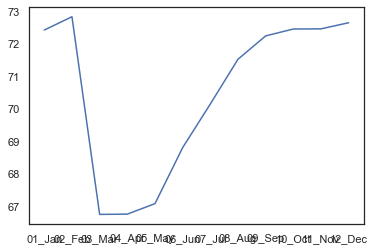

<Figure size 432x288 with 0 Axes>

In [118]:
# Plot weighted average monthly price over year - IGNORE AS LOGICALLY REFLECTS MAR HIGHEST, APR LOWEST
lists = sorted(mth_avg_weight.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()
plt.tight_layout()

In [119]:
# Fill empty cells with values from next period
data_ts_filled = data_ts.copy()
for i, col in enumerate(data_ts_filled.columns):
    if i > 0:
        data_ts_filled[col] = data_ts_filled[col].fillna(data_ts_filled[data_ts_filled.columns[i-1]])
data_ts_filled.head()

,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,
3176,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
3309,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
6883,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0
7071,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,34.0,42.0,42.0,42.0,42.0,47.0,47.0,47.0,47.0,47.0,40.0
9991,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0


In [120]:
# Create column with calculated weighted average price
#weight = 0.4
#price_avg = []
#for 
data["price_avg"] = data_ts_filled.iloc[:,0]*0.5 + data_ts_filled.iloc[:,7]*0.25 + data_ts_filled.iloc[:,15]*0.15 + data_ts_filled.iloc[:,22]*0.10 

In [121]:
# Create column with calculated price difference between current price and weighted average price
data["price_diff"] = data.price - data.price_avg

In [122]:
# Create column with calculated price difference as percentage
data["price_diff_perc"] = data.price_diff / data.price

In [123]:
# Output individual listings from data for review
#data[data.index==42343281]

In [124]:
# Output individual listings from data_ts for review
data_ts[data_ts.index==36609709]

,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,
36609709,350.0,72.0,77.0,77.0,77.0,77.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
# Output individual listings from data_ts_filled for review
data_ts_filled[data_ts_filled.index==36609709]

,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,
36609709,350.0,72.0,77.0,77.0,77.0,77.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [126]:
# Check highest price vs avg differences
data[data.price_diff_perc>0.33].head()

,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_identity_verified,host_is_superhost,host_listings_count,house_rules,instant_bookable,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,monthly_price,name,neighbourhood,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,room_type,security_deposit,space,summary,weekly_price,zipcode,avg_nights,reviews_lt2yr,active_months_lt2yr,bookings_est,occupancy_rate,occupancy_class,price_avg,price_diff,price_diff_perc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
593920,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"{Internet,Wifi,Kitchen,""Free parking on premis...",0,1.0,1.0,2.0,1,strict_14_with_grace_period,1,"A cosy, artsy apartment, centrally located, fo...",0.0,1,f,f,1.0,1,f,t,52.49517,13.40122,1125,1,1,"1,5 rooms in wonderful Kreuzberg",Kreuzberg,179.0,10.0,9.0,10.0,10.0,10.0,10.0,Entire home/apt,1,1,"A cosy, artsy apartment, centrally located, fo...",1,zip_10961,3.0,0.0,23,0.0,0.000000,0,107.0,72.0,0.402235
1564806,6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",77,1.5,1.0,1.0,49,strict_14_with_grace_period,1,"with 12-man communal shared bathroom, TV, WIFI...",23.0,1,f,f,49.0,1,f,t,52.51614,13.42485,14,1,0,"6-Bed mixed dorm ,Shared Bathroom 3",Mitte,150.0,10.0,10.0,9.0,10.0,9.0,9.0,Shared room,1,1,"with 12-man communal shared bathroom, TV, WIFI...",0,zip_10179,3.0,66.0,23,132.0,0.800000,5,85.0,65.0,0.433333
1564917,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",85,1.5,1.0,1.0,49,strict_14_with_grace_period,1,"with bathroom, TV, WIFI, bed linen, and storag...",29.0,1,f,f,49.0,1,f,t,52.51767,13.42518,14,1,0,"4-Bedroom mixed, Ensuite , TV No. 1",Mitte,99.0,10.0,10.0,10.0,10.0,10.0,9.0,Shared room,1,1,"with bathroom, TV, WIFI, bed linen, and storag...",0,zip_10179,3.0,92.0,23,184.0,0.800000,5,66.0,33.0,0.333333
1565012,6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",86,1.5,1.0,1.0,49,strict_14_with_grace_period,1,"with en-suite bathroom, TV, WIFI, bed linen, a...",27.0,1,f,f,49.0,1,f,t,52.51756,13.42441,14,1,0,"6-Bedroom mixed, Ensuite , TV No. 1",Mitte,150.0,10.0,10.0,9.0,10.0,9.0,9.0,Shared room,1,1,"with en-suite bathroom, TV, WIFI, bed linen, a...",0,zip_10179,3.0,55.0,23,110.0,0.800000,5,87.5,62.5,0.416667
1565047,8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,Kitchen,Elevator,Heating,""Fa...",76,1.0,1.0,1.0,49,strict_14_with_grace_period,1,"with en-suite bathroom, TV, WIFI, bed linen, a...",23.0,1,f,f,49.0,1,f,t,52.51778,13.42640,14,1,0,"8-bed dorm mixed Ensuite ,Kitchen 1",Mitte,150.0,9.0,10.0,9.0,9.0,9.0,9.0,Shared room,1,1,"with en-suite bathroom, TV, WIFI, bed linen, a...",0,zip_10179,3.0,36.0,23,72.0,0.591781,3,91.0,59.0,0.393333


## Other Features

**Change column content**

In [127]:
# Reduce cancellation_policy to 4 classes
data.cancellation_policy.replace(["strict_14_with_grace_period", "super_strict_60", "super_strict_30"], ["strict", "super_strict", "super_strict"], inplace=True)

**Convert binary features to 1/0**

In [128]:
# Convert t/f to 1/0 for various features
data.host_is_superhost.replace(["t", "f"], [1, 0], inplace=True)
data.host_identity_verified.replace(["t", "f"], [1, 0], inplace=True)
data.is_location_exact.replace(["t", "f"], [1, 0], inplace=True)
data.instant_bookable.replace(["t", "f"], [1, 0], inplace=True)

In [129]:
# Change availability_365 to 1/0
data.availability_365.where(data.availability_365!=0, 1, inplace=True)


**Create log from existing features** (see 2_Clean)

In [ ]:
# Create log "accommodates_log" for numerical feature "accommodates"
data["accommodates_log"] = [math.log(el) for el in data["accommodates"]]

In [ ]:
# Create log "bathrooms_log" for numerical feature "bathrooms"
data["bathrooms_log"] = [math.log(el) for el in data["bathrooms"]]

In [ ]:
# Create log "minimum_nights_log" for numerical feature "minimum_nights"
data["minimum_nights_log"] = [math.log(el) for el in data["minimum_nights"]]

In [ ]:
# Create log "price_log" for numerical feature "price"
data["price_log"] = [math.log(el) for el in data["price"]]

In [139]:
# Create log "review_scores_rating_log" for numerical feature "review_scores_rating"
review_max = data.review_scores_rating.max()
data["review_scores_rating_log"] = [math.log((review_max-el)) for el in data.review_scores_rating]
review_log_max = data.review_scores_rating_log.max()
data["review_scores_rating_log"] = [(review_log_max-el) for el in data.review_scores_rating_log]
#data["review_scores_rating_log"].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');

AttributeError: 'DataFrame' object has no attribute 'review_scores_rating'

**Create categorical features**

In [130]:
# Categorize listings by "state" (basic, moderate, luxurious)

In [131]:
# Modify text-based columns by counting words (.split().count)
# Count length of summary in words
# Count length of description in words

**Final check and cleaning before export**

In [132]:
# Drop further columns
data.drop(["accommodates", "amenities", "avg_nights", "bathrooms", "reviews_lt2yr", 
           "active_months_lt2yr", "bookings_est", "minimum_nights", "price", "review_scores_rating"
           "description", "name", "price_avg", "price_diff", "price_diff_perc", "summary"
          ], inplace=True, axis=1)

Notes:
- xyz

In [133]:
# Review datatypes (data.info()) (post-engineering)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24527 entries, 3176 to 42361801
Data columns (total 50 columns):
accommodates                      24527 non-null int64
am_balcony                        24527 non-null float64
am_breakfast                      24527 non-null float64
am_child_friendly                 24527 non-null float64
am_coffee_machine                 24527 non-null float64
am_cooking_basics                 24527 non-null float64
am_elevator                       24527 non-null float64
am_essentials                     24527 non-null float64
am_nature_and_views               24527 non-null float64
am_parking                        24527 non-null float64
am_pets_allowed                   24527 non-null float64
am_private_entrance               24527 non-null float64
am_smoking_allowed                24527 non-null float64
am_tv                             24527 non-null float64
am_white_goods                    24527 non-null float64
availability_365                

In [134]:
# Sort columns in dataset
data = data.reindex(sorted(data.columns, reverse=False), axis=1)

In [135]:
# Display engineered dataset
print(data.shape)
data.head(3)

(24527, 50)


,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,extra_people,guests_included,host_identity_verified,host_is_superhost,host_listings_count,house_rules,instant_bookable,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,monthly_price,neighbourhood,occupancy_class,occupancy_rate,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,room_type,security_deposit,space,weekly_price,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,221,1.0,1.0,2.0,1,strict,1,20.0,2,1,0,1.0,1,0,1,52.53500,13.41758,1125,62,1,Prenzlauer Berg,4,0.679452,90.0,9.0,9.0,9.0,9.0,10.0,9.0,Entire home/apt,1,1,1,zip_10405
3309,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,293,1.0,1.0,1.0,1,strict,1,18.0,1,0,0,1.0,1,0,1,52.49885,13.34906,35,7,1,Schöneberg,1,0.176438,28.0,9.0,9.0,9.0,10.0,9.0,9.0,Private room,1,1,1,zip_10777
6883,2,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8,1.0,1.0,1.0,1,moderate,1,0.0,1,1,0,1.0,1,0,1,52.51171,13.45477,90,3,1,Friedrichshain,3,0.441096,125.0,10.0,10.0,10.0,10.0,10.0,10.0,Entire home/apt,1,1,1,zip_10243


**Export data_engineered**

In [136]:
# Export dataset for further use in 4_Predictive Modeling
data.to_pickle("saves/data_engineered.pkl")

In [137]:
# Alternative: Export with to_csv and save dtypes separately
#data.to_csv(r'saves/data_engineered.csv', index = True)
#data.dtypes.to_frame('types').to_csv('saves/types_engineered.csv')